In this HW, you will implement a Conditional Image to Image GAN for image translations. You can read more about it [here](https://towardsdatascience.com/gan-pix2pix-generative-model-c9bf5d691bac).

You are to set and train your GAN on the provided dataset. After training, show 10 edge to shoes translations from the val set. Also, you show you model's performance on three of your own sketches.

The edge-shoe pair is in the form of a single long image. So, you will need to split it before using.

In [4]:
from IPython.display import clear_output

In [5]:
# %pip install gdown
# clear_output()

In [6]:
# import gdown
# gdown.download("https://drive.google.com/uc?id=1K6aoVgwhYeFpAUbHR0-9lnbhaS7g4jGs")

In [7]:
# If you get download limit reached error from above.
# You can either manually download the data from gdrive and upload to colab or just directly download from main source using the following command. This is slower though.

# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz

In [8]:
# !tar -zxf edges2shoes.tar.gz

## Dataset

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from tqdm import tqdm

In [10]:
import os
from torchvision.io import read_image

class Pix2PixDataset(Dataset):
    def __init__(self, root, train=True, transforms=None):
        self.split = 'train' if train else 'val'
        self.root = os.path.join(root, self.split)
        self.data = [os.path.join(self.root, f) for f in os.listdir(self.root)]
        self.transforms = transforms
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = read_image(self.data[idx]).type(torch.float) / 255.0
        pix, img = torch.split(img, int(img.size(2)/2), dim=2)
        if self.transforms is not None:
            pix = self.transforms(pix)
            img = self.transforms(img)
        return pix, img
    

In [11]:
set_transforms = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((128, 128))
])

In [12]:
train_set = Pix2PixDataset('../input/edges2shoes-dataset', train=True, transforms=set_transforms)
val_set = Pix2PixDataset('../input/edges2shoes-dataset', train=False, transforms=set_transforms)

In [13]:
def denormalize_image(image):
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    denormalized_image = image * std + mean
    return denormalized_image

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.) tensor(-0.5000)


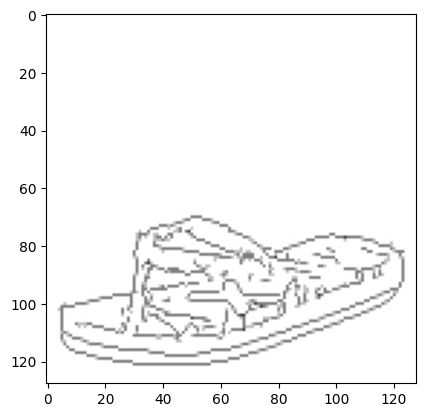

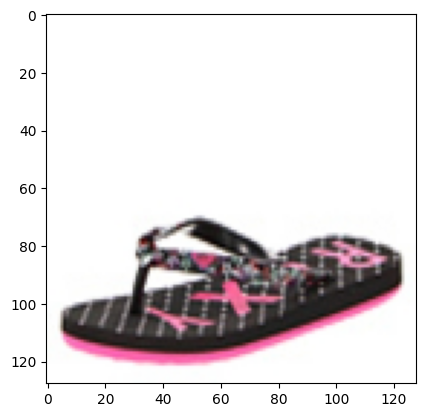

In [14]:
import matplotlib.pyplot as plt
pix, img = train_set[0]
print(pix.max(), pix.min())
plt.imshow(denormalize_image(pix).permute(1, 2, 0))
plt.show()
plt.imshow(denormalize_image(img).permute(1, 2, 0))

In [15]:
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [16]:
def unet_conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )

In [17]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block1 = unet_conv_block(in_channels, out_channels)
        self.conv_block2 = unet_conv_block(out_channels, out_channels)
        self.pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        x1 = self.conv_block1(x)
        x2 = self.conv_block2(x1)
        x3 = self.pool(x2)
        return x3, x1

In [18]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block1 = unet_conv_block(in_channels, out_channels)
        self.conv_block2 = unet_conv_block(out_channels, out_channels)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, enc, dropout=False):
        x = self.trans_conv(x)
        x = torch.cat([x, enc], dim=1)
        if dropout: x = self.dropout(x)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return x

In [19]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = EncoderBlock(3, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bottleneck = nn.Sequential(
            unet_conv_block(512, 1024),
            unet_conv_block(1024, 1024)
        )

        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, x):
        x, enc1 = self.enc1(x)
        x, enc2 = self.enc2(x)
        x, enc3 = self.enc3(x)
        x, enc4 = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, enc4, dropout=True)
        x = self.dec2(x, enc3, dropout=True)
        x = self.dec3(x, enc2, dropout=True)
        x = self.dec4(x, enc1, dropout=True)

        x = self.final(x)

        return x

In [33]:
def conv_block(in_channels, out_channels, relu=True, stride=1, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(out_channels),
    ]
    if relu: layers.append(nn.LeakyReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(6, 64)

        self.res1 = nn.Sequential(conv_block(64, 64, pool=True), conv_block(64, 64, relu=False)) # 128 x 128
        self.upsample1 = nn.Conv2d(64, 64, kernel_size=2, stride=2)

        self.res2 = nn.Sequential(conv_block(64, 128, pool=True), conv_block(128, 128, relu=False)) # 64 x 64
        self.upsample2 = nn.Conv2d(64, 128, kernel_size=2, stride=2)

        self.res3 = nn.Sequential(conv_block(128, 256, pool=True), conv_block(256, 256, relu=False)) # 32 x 32
        self.upsample3 = nn.Conv2d(128, 256, kernel_size=2, stride=2)

        self.res4 = nn.Sequential(conv_block(256, 512, pool=True), conv_block(512, 512, relu=False)) # 16 x 16
        self.upsample4 = nn.Conv2d(256, 512, kernel_size=2, stride=2)
        
        self.final = nn.Sequential(
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(512, 1, kernel_size=3, stride=1)
        )

#         self.fc = nn.Sequential(
#             nn.AvgPool2d(kernel_size=2), # 8 x 8
#             nn.Flatten(),
#             nn.Linear(512 * 4 * 4, 2048),
#             nn.LeakyReLU(),
#             nn.Linear(2048, 1)
#         )

        self.relu = nn.LeakyReLU()

    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        x = self.conv1(x)
        x = self.relu(self.res1(x) + self.upsample1(x))
        x = self.relu(self.res2(x) + self.upsample2(x))
        x = self.relu(self.res3(x) + self.upsample3(x))
        x = self.relu(self.res4(x) + self.upsample4(x))
        x = self.final(x)
        return x

## Training

In [34]:
torch.cuda.is_available()

True

Epoch [1/5]: 100%|██████████| 779/779 [10:18<00:00,  1.26it/s, loss_d=0.37, loss_g=18.6] 


Epoch [1/5] - Train Loss G: 20.3387, Train Loss D: 0.3291, Val Loss G: 0.2053


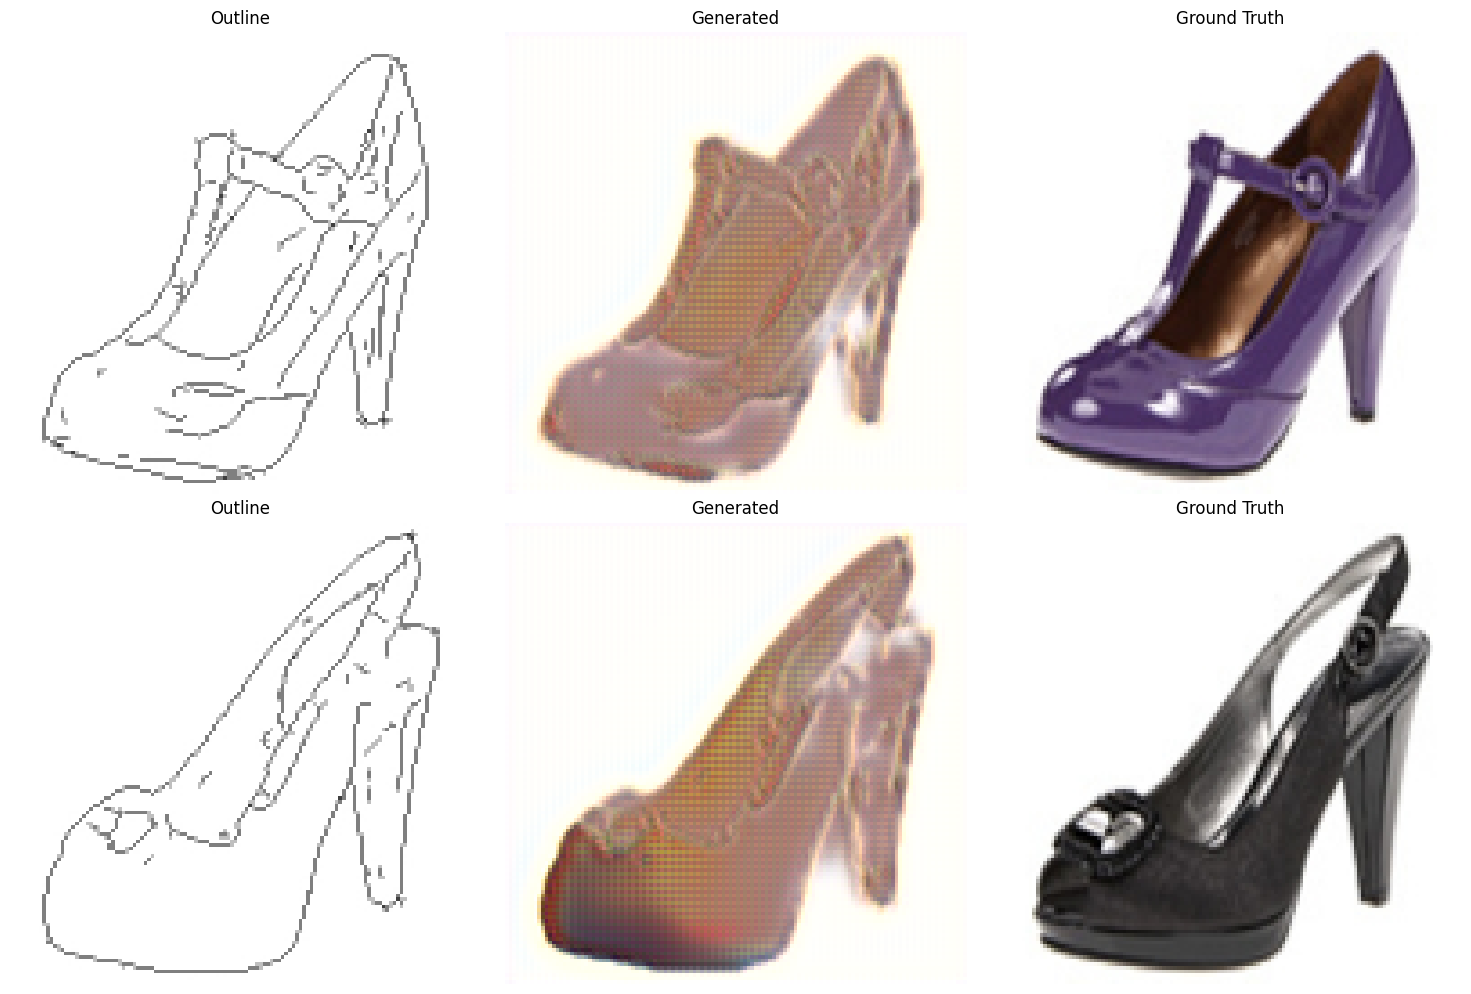

Epoch [2/5]: 100%|██████████| 779/779 [10:18<00:00,  1.26it/s, loss_d=0.656, loss_g=16.6]


Epoch [2/5] - Train Loss G: 18.3775, Train Loss D: 0.3300, Val Loss G: 0.1978


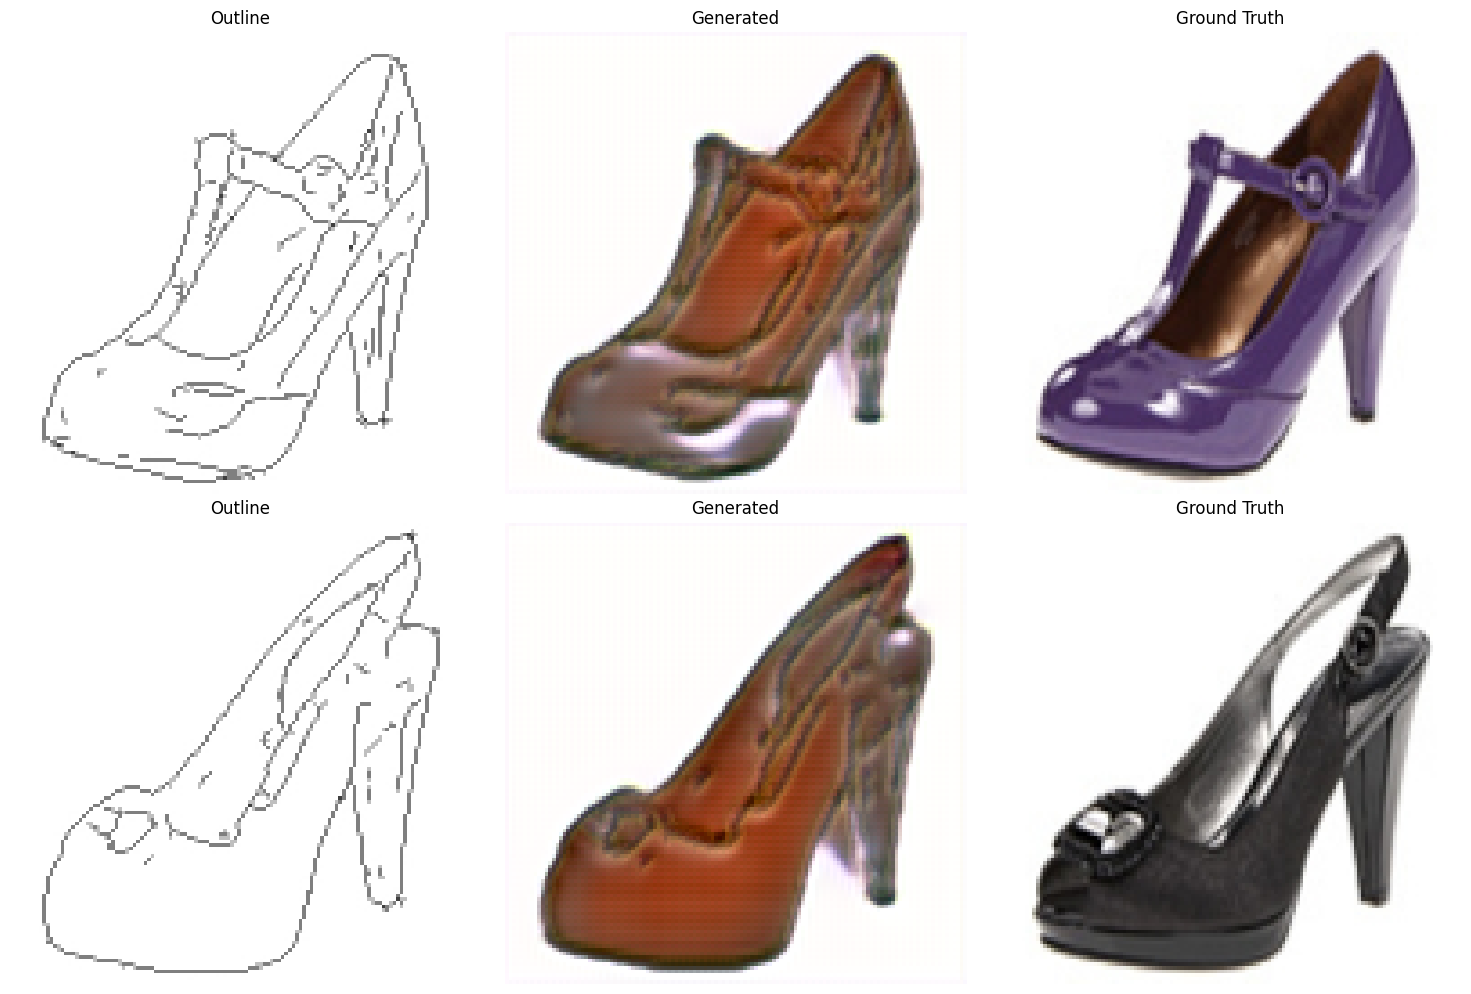

Epoch [3/5]: 100%|██████████| 779/779 [10:18<00:00,  1.26it/s, loss_d=0.548, loss_g=18.1]


Epoch [3/5] - Train Loss G: 19.0010, Train Loss D: 0.3011, Val Loss G: 0.1952


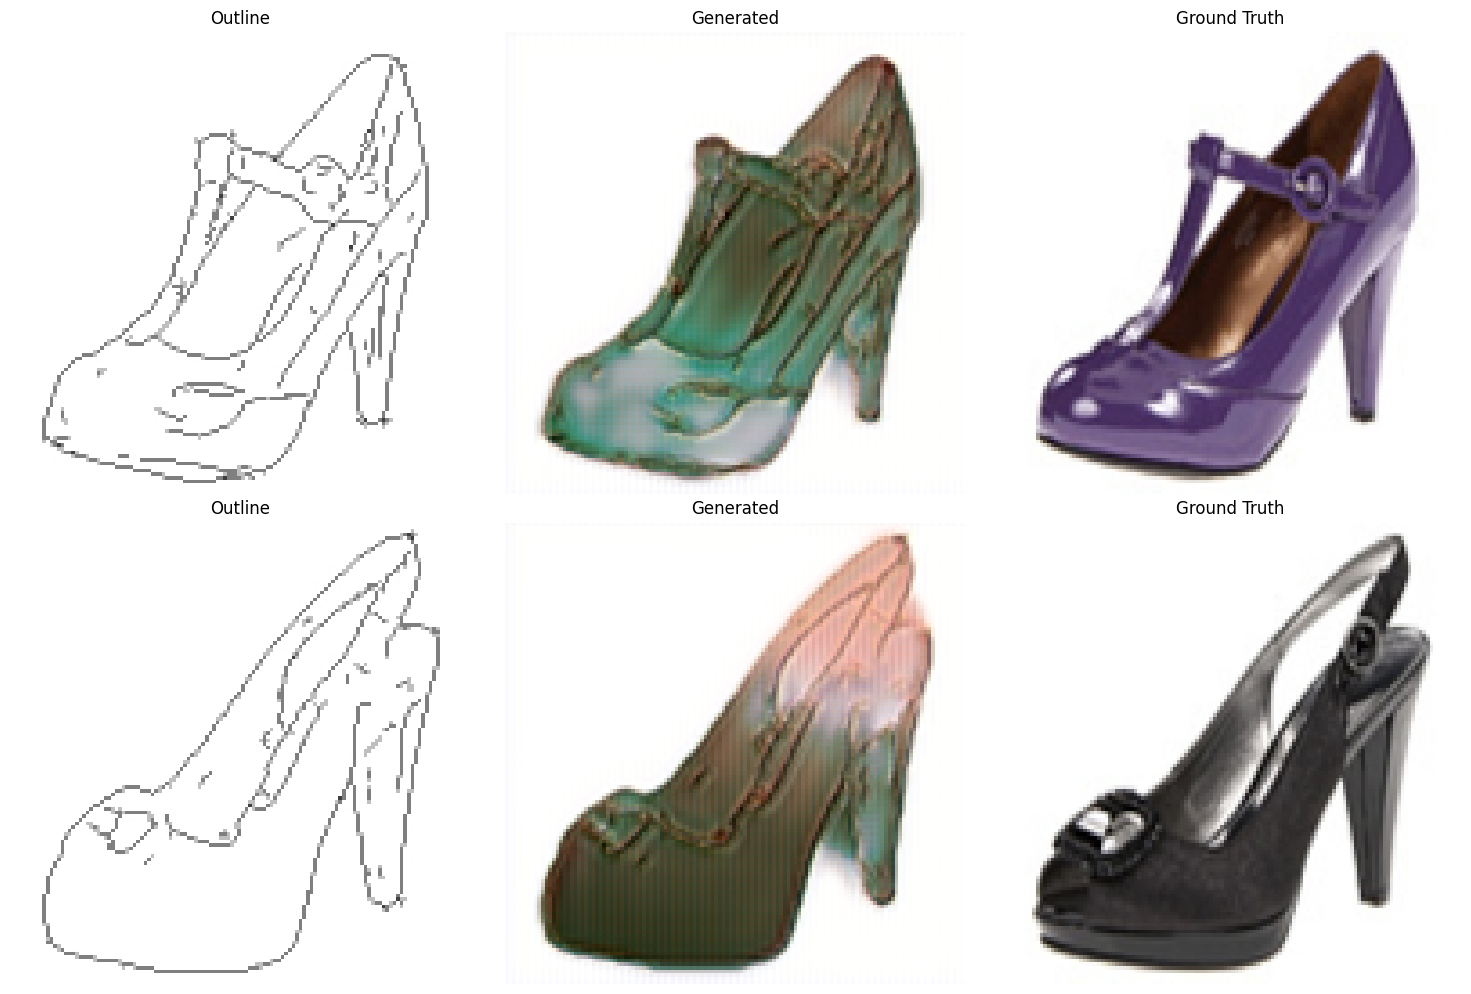

Epoch [4/5]: 100%|██████████| 779/779 [10:18<00:00,  1.26it/s, loss_d=0.182, loss_g=22.4]


Epoch [4/5] - Train Loss G: 18.8474, Train Loss D: 0.2458, Val Loss G: 0.2002


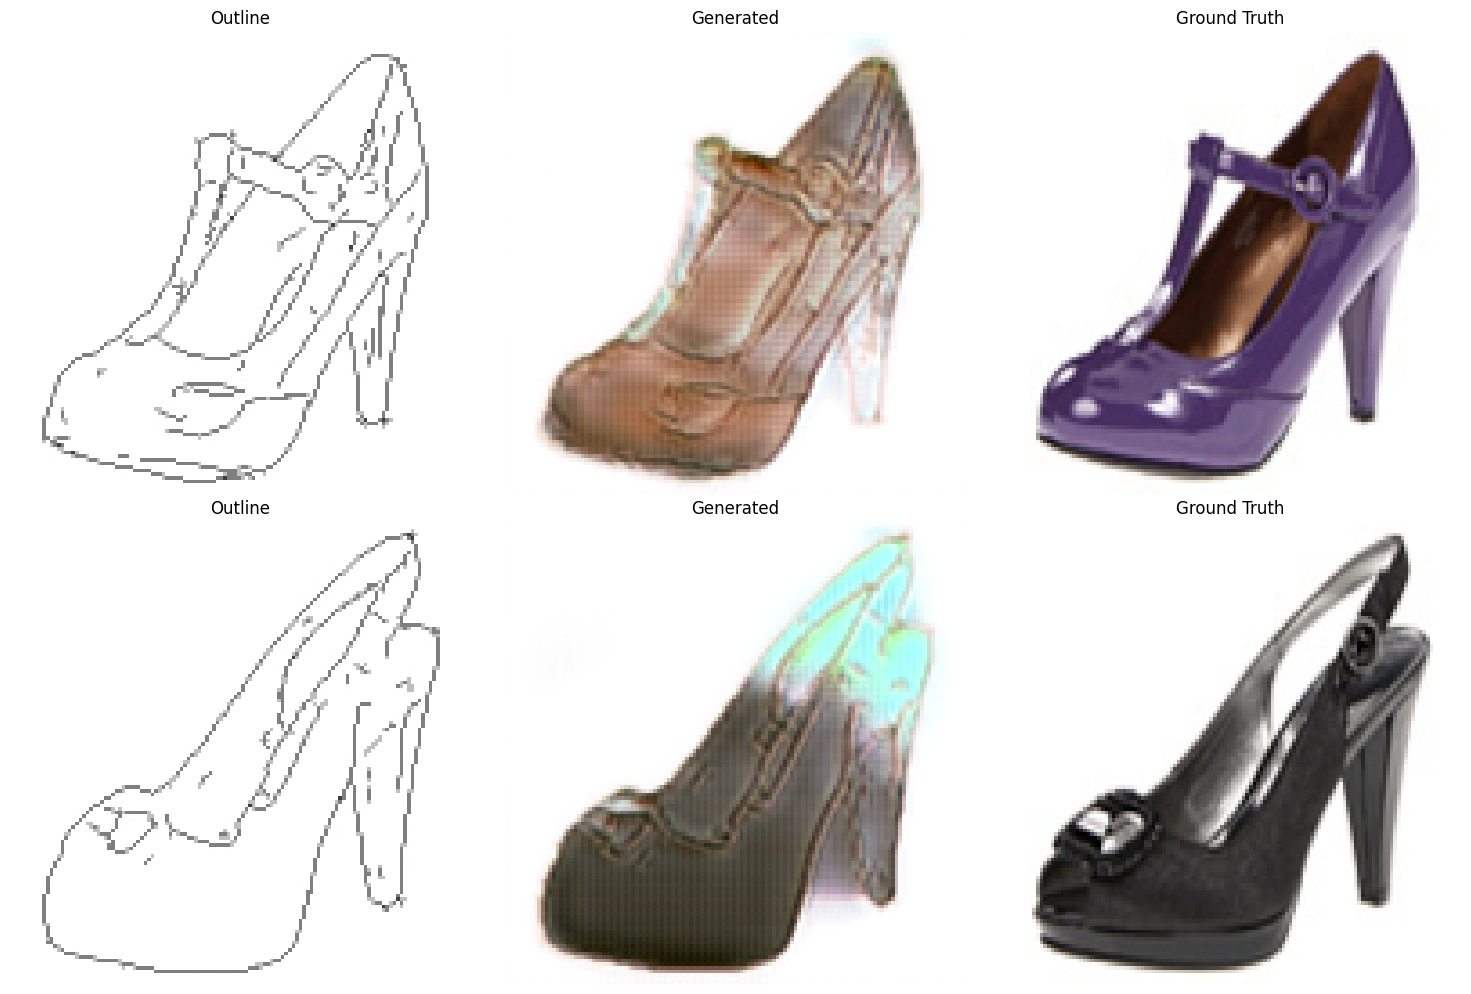

Epoch [5/5]: 100%|██████████| 779/779 [10:18<00:00,  1.26it/s, loss_d=0.344, loss_g=22.5]


Epoch [5/5] - Train Loss G: 20.0632, Train Loss D: 0.2248, Val Loss G: 0.2196


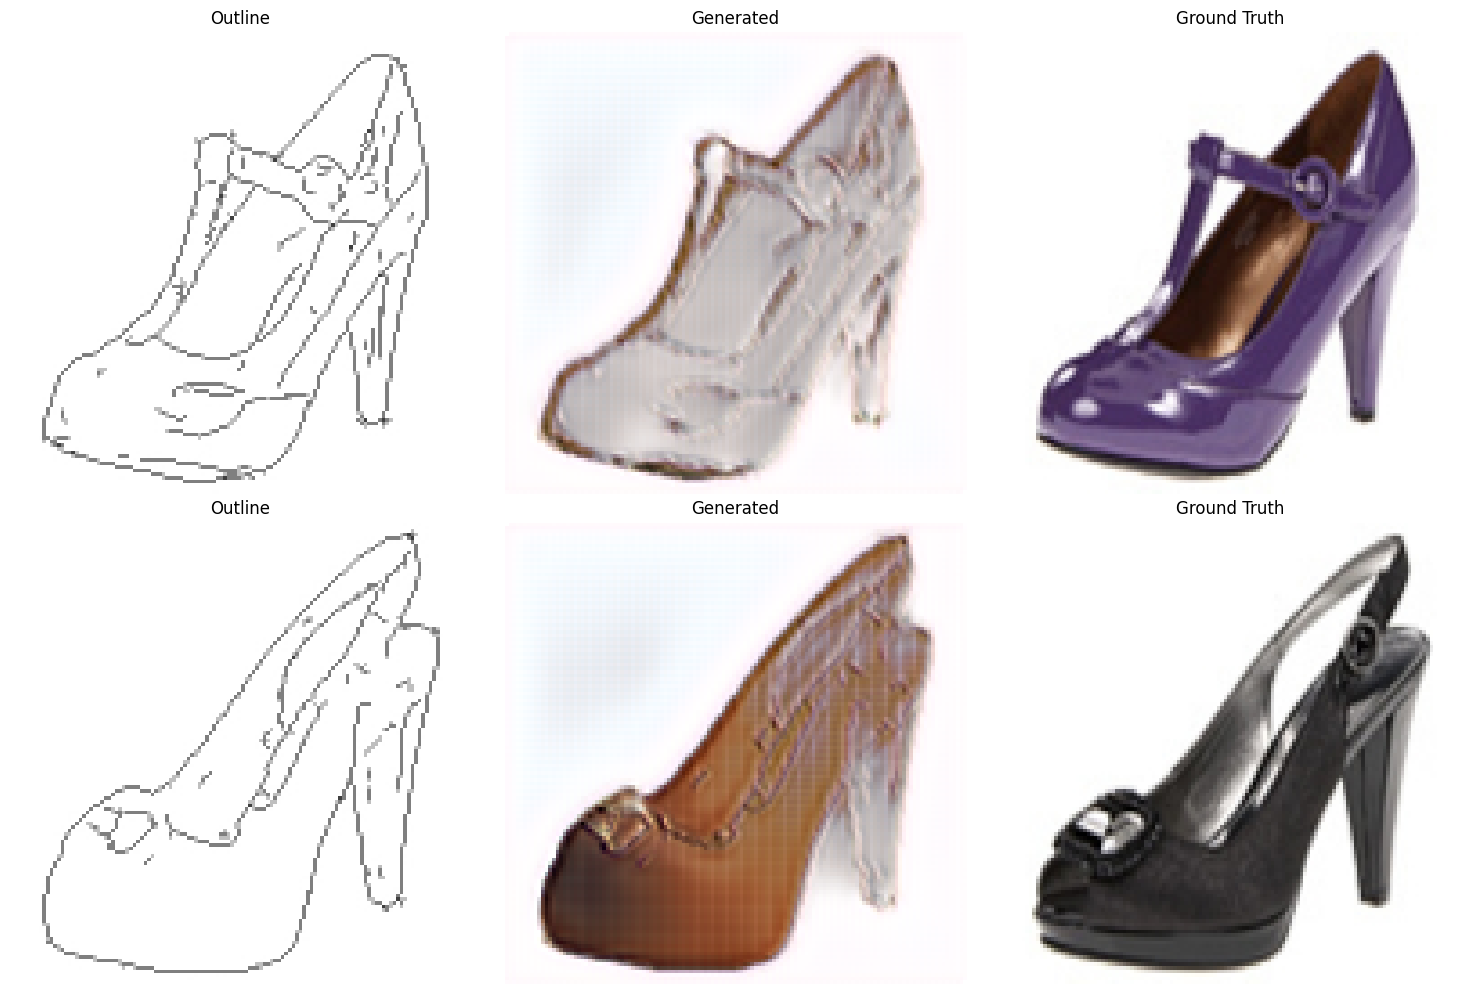

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = UNetGenerator().to(device)
discriminator = ResNet9Discriminator().to(device)

# generator = nn.DataParallel(generator, device_ids=[0, 1]).to(device)
# discriminator = nn.DataParallel(discriminator, device_ids=[0, 1]).to(device)

criterion_gan = nn.BCEWithLogitsLoss()
criterion_l1 = nn.L1Loss()

optimizer_g = optim.AdamW(generator.parameters(), lr=3e-4)
optimizer_d = optim.AdamW(discriminator.parameters(), lr=3e-4)

epochs = 5
lambda_l1 = 75  # Weight for L1 loss

train_losses_g = []
train_losses_d = []
val_losses_g = []

# Training loop
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    
    # Initialize losses
    epoch_loss_g = 0
    epoch_loss_d = 0
    
    loop = tqdm(train_loader, leave=True)
    
    for batch_idx, (x, y) in enumerate(loop):

        real_label = torch.full((x.size(0), 1, 2, 2), 0.9, dtype=torch.float32, device=device)
        fake_label = torch.zeros((x.size(0), 1, 2, 2), dtype=torch.float32, device=device)

        x, y = x.to(device), y.to(device)
        
        # Train Discriminator
        optimizer_d.zero_grad()
        
        # Real images
        output_real = discriminator(x, y)
        loss_d_real = criterion_gan(output_real, real_label)
        
        # Fake images
        fake_y = generator(x)
        output_fake = discriminator(x, fake_y.detach())
        loss_d_fake = criterion_gan(output_fake, fake_label)
        
        loss_d = (loss_d_real + loss_d_fake) / 2
        loss_d.backward()
        optimizer_d.step()
        
        # Train Generator
        optimizer_g.zero_grad()
        
        output_fake = discriminator(x, fake_y)
        loss_g_gan = criterion_gan(output_fake, real_label)
        
        loss_g_l1 = criterion_l1(fake_y, y) * lambda_l1
        
        loss_g = loss_g_gan + loss_g_l1
        
        loss_g.backward()
        optimizer_g.step()
        
        train_losses_g.append(loss_g.item())
        train_losses_d.append(loss_d.item())
        
        epoch_loss_g += loss_g.item()
        epoch_loss_d += loss_d.item()

        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss_g=loss_g.item(), loss_d=loss_d.item())
    
    # Average losses for this epoch
    avg_loss_g = epoch_loss_g / len(train_loader)
    avg_loss_d = epoch_loss_d / len(train_loader)

    # Validation
    generator.eval()
    val_loss_g = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            fake_y = generator(x)
            val_loss_g += criterion_l1(fake_y, y).item()
        
    val_loss_g /= len(val_loader)
    val_losses_g.append(val_loss_g)
    
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss G: {avg_loss_g:.4f}, Train Loss D: {avg_loss_d:.4f}, Val Loss G: {val_loss_g:.4f}")
    display_images(num_samples=2)
    

## Results

In [46]:
import matplotlib.pyplot as plt

def plot_losses(train_losses_g, train_losses_d, val_losses_g):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].plot(train_losses_g, color='blue', linewidth=1)
    axs[0].set_title('Generator Training Loss')
    axs[0].set_xlabel('Training Steps')
    axs[0].set_ylabel('Loss')

    axs[1].plot(train_losses_d, color='orange', linewidth=1)
    axs[1].set_title('Discriminator Training Loss')
    axs[1].set_xlabel('Training Steps')
    axs[1].set_ylabel('Loss')

    val_steps = len(train_losses_g) // len(val_losses_g)
    val_x = [val_steps * (i + 1) for i in range(len(val_losses_g))]
    axs[2].plot(val_losses_g, color='green', linewidth=2, linestyle='--')
    axs[2].set_title('Generator Validation Loss')
    axs[2].set_xlabel('Training Steps')
    axs[2].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()



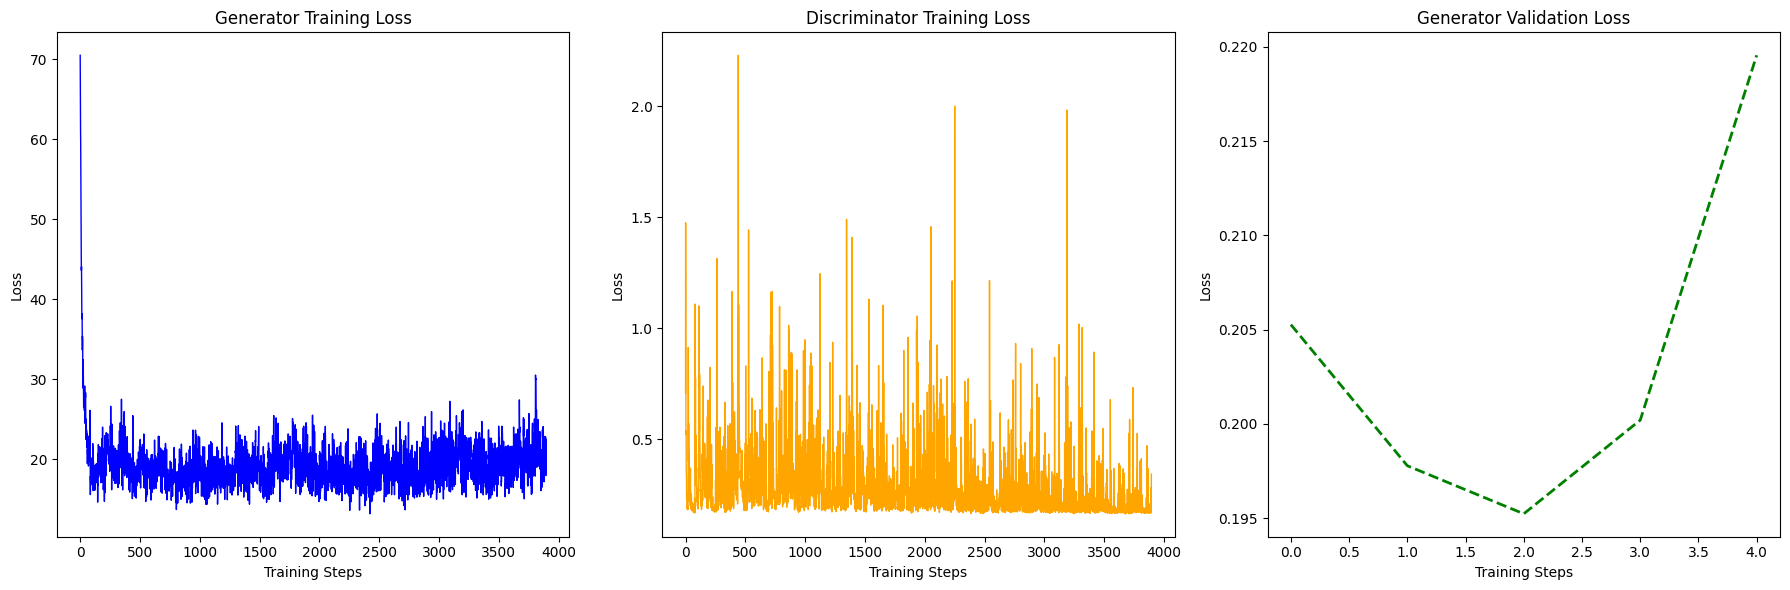

In [47]:
plot_losses(train_losses_g, train_losses_d, val_losses_g)

In [48]:
def display_images(num_samples=10):
    generator.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

    for i in range(num_samples):
        img, ground_truth = val_set[i]
        img = img.unsqueeze(0).to(device)
        generated_img = generator(img)

        axes[i, 0].imshow(denormalize_image(img[0].cpu().detach()).permute(1, 2, 0))
        axes[i, 0].set_title('Outline')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(denormalize_image(generated_img[0].cpu().detach()).permute(1, 2, 0))
        axes[i, 1].set_title('Generated')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(denormalize_image(ground_truth.cpu().detach()).permute(1, 2, 0))
        axes[i, 2].set_title('Ground Truth')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

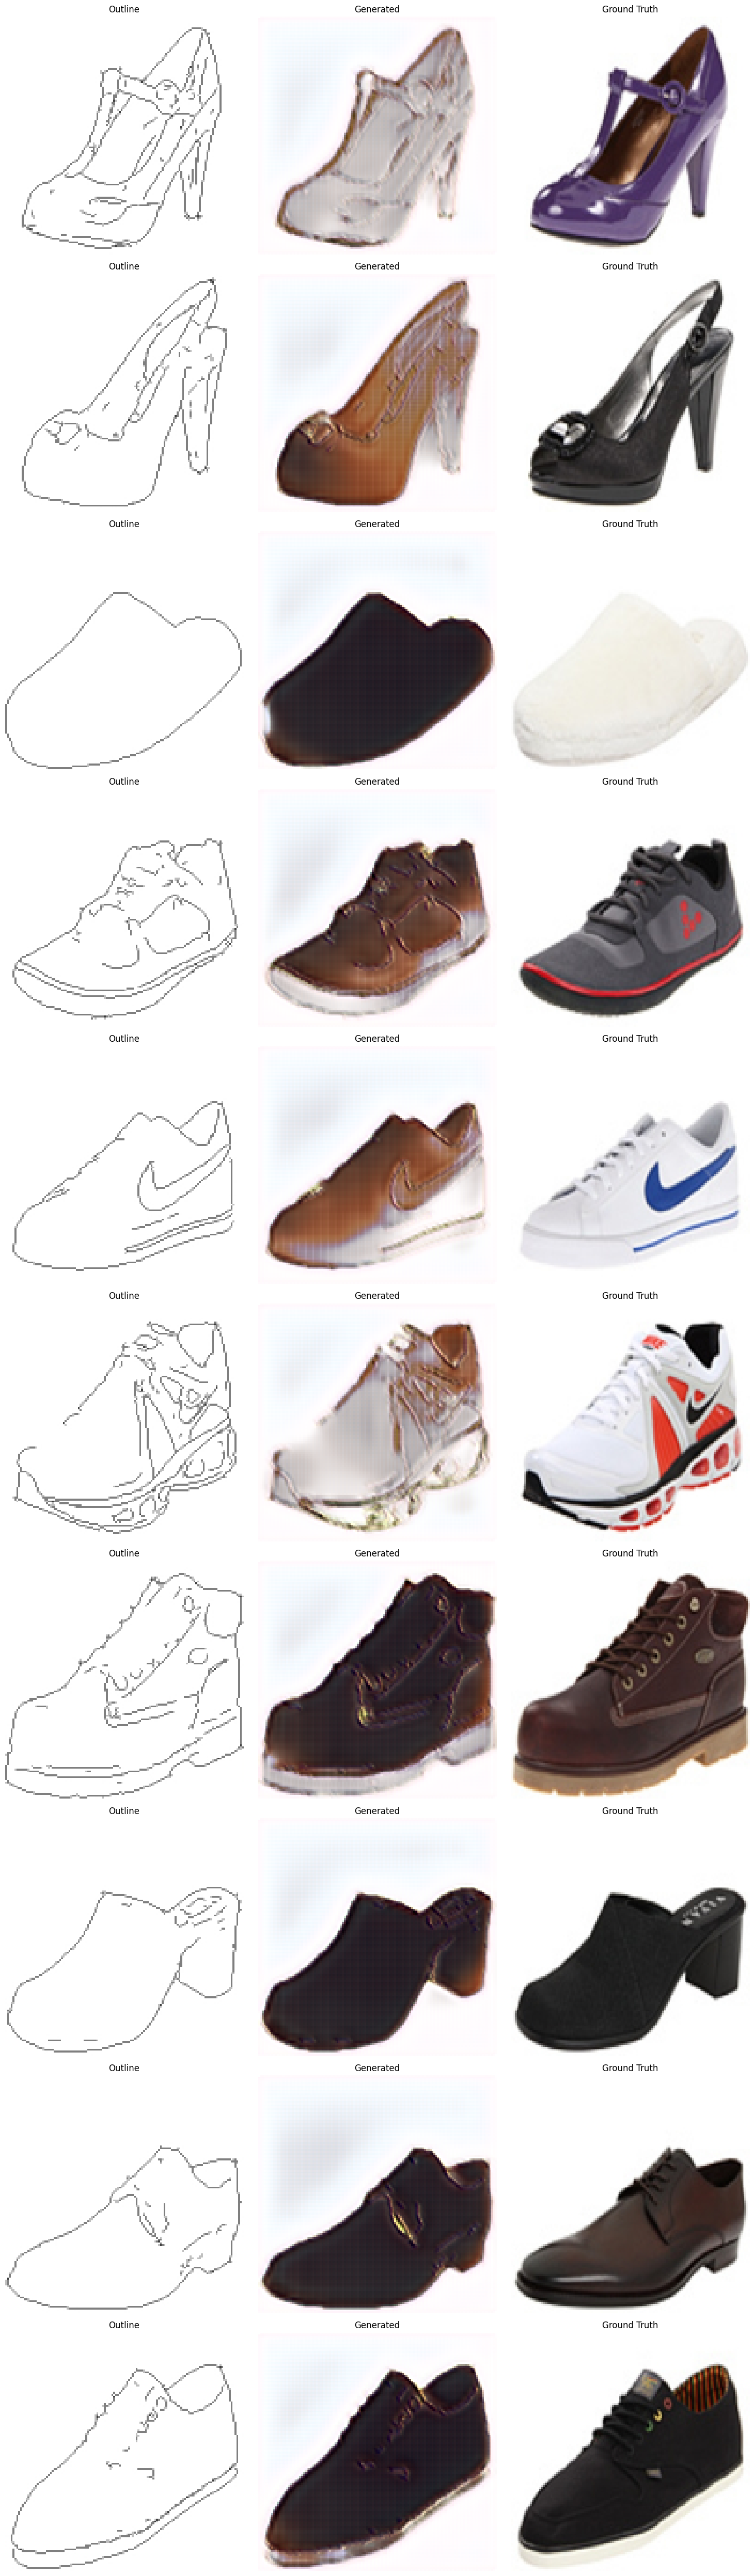

In [49]:
display_images(10)

In [50]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')